<a href="https://colab.research.google.com/github/mohammad2682/Covid-19/blob/master/segment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install dicom

In [10]:
!git clone https://github.com/mohammad2682/Covid19-Dataset

Cloning into 'Covid19-Dataset'...
remote: Enumerating objects: 3253, done.
remote: Total 3253 (delta 0), reused 0 (delta 0), pack-reused 3253
Receiving objects: 100% (3253/3253), 315.60 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (5710/5710), done.


In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np 
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [20]:
# Some constants 


INPUT_FOLDER = 'Covid19-Dataset/Covid-19-Dataset/train/COVID/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

test_patient_scans = load_scan(INPUT_FOLDER + patients[8])
test_patient_images = get_pixels_hu(test_patient_scans)
print ("Original Slice")
plt.imshow(test_patient_images[65], cmap='gray')
plt.show()

NotADirectoryError: ignored

In [55]:
disease_types=['COVID', 'non-COVID']
data_dir = 'Covid19-Dataset/Covid-19-Dataset/train'
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

IMAGE_SIZE = 128
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

from tqdm import tqdm
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.

Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

SEED=42
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

2000it [00:09, 207.09it/s]


(128, 128, 3)


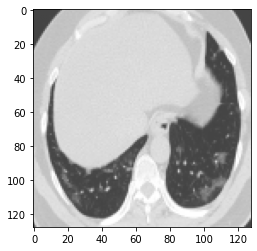

In [62]:

img=X_train
img=img[2]
print(img.shape)
plt.imshow(img, cmap='gray')

In [77]:
# Some of the starting Code is taken from ArnavJain, since it's more readable then my own
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((128,128), dtype=np.int)
    marker_watershed += marker_internal * 12
    marker_watershed += marker_external * 12
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(img)
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external,cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

ValueError: ignored

In [67]:
img.shape[1]


128